# **BBM 409: Machine Learning Laboratory 👨🏻‍🔬**
### **Project Assignment 1**  

### **Group 13**

- **Mert Çetin** - 2220356148  
- **Mehmet Oğuz Kocadere** - 2210356021  

### **Environment**  
- **Python Version**: 3.9.6  

# **Part I: Textual Data Analysis ✍🏻**

In [2]:
%pip install pandas

import pandas as pd # Version 2.2.3

file_path = "BBM409_S25_PA1_Dataset_v1/part_i.csv"
df = pd.read_csv(file_path)

Note: you may need to restart the kernel to use updated packages.


Could not find platform independent libraries <prefix>

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%pip install numpy scikit-learn matplotlib seaborn

import numpy as np # Version 2.0.2

# To visualize
import matplotlib.pyplot as plt # Version 3.9.4
import seaborn as sns # Version 0.13.2

import time

# scikit-learn Version 1.6.1
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

Could not find platform independent libraries <prefix>

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [4]:
# Identify numeric and categorical columns
numeric_cols = df.select_dtypes(include

                                =['number']).columns  # Select numeric columns
categorical_cols = df.select_dtypes(exclude=['number']).columns  # Select categorical columns (CLASS)

# Number of numerical and categorical columns
num_numerical_features = len(numeric_cols)
num_categorical_features = len(categorical_cols)

print(f"Total numerical features: {num_numerical_features}")
print(f"Total categorical features: {num_categorical_features}")

Total numerical features: 106
Total categorical features: 1



Missing values in categorical columns:
 Series([], dtype: int64)


C:\Users\canme\AppData\Local\Temp\ipykernel_22304\2571212901.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_missing_numerical.index, y=top_missing_numerical.values, hue=None, legend=False, palette="viridis")


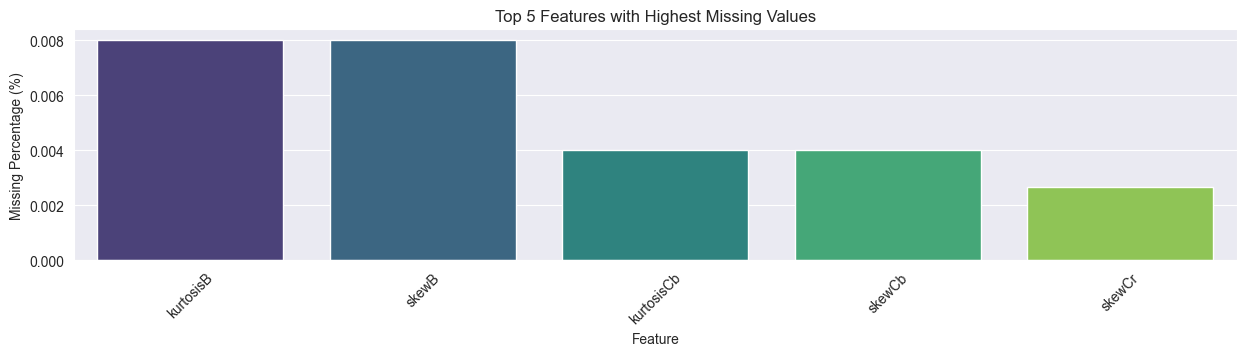

In [5]:
# Check for missing values in categorical columns
missing_categorical = df[categorical_cols].isnull().sum()
print("\nMissing values in categorical columns:\n", missing_categorical[missing_categorical > 0])

# Calculate missing percentage for numerical columns
missing_numerical_percentages = (df[numeric_cols].isnull().sum() / len(df)) * 100

# List the top 5 numerical features with the highest missing percentage
top_missing_numerical = missing_numerical_percentages.sort_values(ascending=False).head(5)

# 📊 Plot the top 5 missing features
plt.figure(figsize=(15, 3))
sns.barplot(x=top_missing_numerical.index, y=top_missing_numerical.values, hue=None, legend=False, palette="viridis")
plt.xlabel("Feature")
plt.ylabel("Missing Percentage (%)")
plt.title("Top 5 Features with Highest Missing Values")
plt.xticks(rotation=45)
plt.show()

## **Handling Missing Values For Numerical Columns 🤔❓ (Mean Imputation)**  

In this assignment, we have decided to fill the missing values using the **mean imputation method** (i.e. completing the missing values with mean values). The dataset contains **106 numerical features and 75,000 samples**. Instead of checking the normality of each feature and deciding what to do with the each attribute's missing values, we have followed a more **pragmatic approach**. Individiually doing that for every attribute would be **time-consuming and inefficient**.

**In previous chart, we checked the missing value percentages** for each feature. If most of the features had extremely high percentages of missing values, We have considered handling it differently. As we can see the most percentage is less than 1%.

To conclude, since this project is **not** related to human life or a medical application, and the proportion of missing values **are lower than 1%**, using mean imputation is an efficient approach for handling missing data in this context.

In [6]:
# Apply mean imputation on numerical columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Merge the whole dataset
df_final = pd.concat([df[numeric_cols], df[categorical_cols]], axis=1)

# Verify missing values after imputation
missing_values_after = df_final.isnull().sum().sum()  # Total missing values
print(f"\nTotal missing values after mean imputation: {missing_values_after}")


Total missing values after mean imputation: 0


## **Visualizing the Difference Between Max and Min Values 📊**

When plotting the feature ranges (difference between min and max values), we noticed that **features with extremely large ranges dominate the visualization**, causing **small-range features to become nearly invisible**.

To **resolve this issue**, we applied **log transformation (`np.log1p`)** to the feature ranges. So this transformation, **prevents** the bigger differences to shadow the smaller ones and **provides** a better comparison.


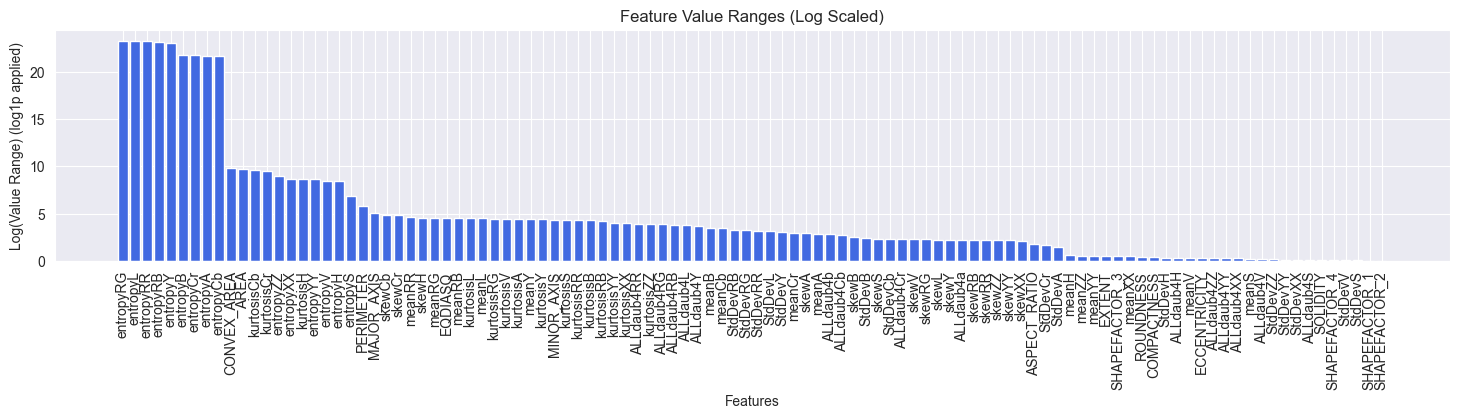

In [7]:
# Checking feature ranges
feature_ranges = df_final.iloc[:, :-1].agg(["min", "max"]).T
feature_ranges["range"] = feature_ranges["max"] - feature_ranges["min"]

# Sorting by range
feature_ranges = feature_ranges.sort_values(by="range", ascending=False)

# Apply log transformation to prevent small values from disappearing (values closer to 0 cannot be seen)
feature_ranges["log_range"] = np.log1p(feature_ranges["range"])

# Plot
plt.figure(figsize=(18, 3))
plt.bar(feature_ranges.index, feature_ranges["log_range"], color="royalblue")
plt.ylabel("Log(Value Range) (log1p applied)")
plt.xlabel("Features")
plt.title("Feature Value Ranges (Log Scaled)")
plt.xticks(rotation=90)
plt.show()

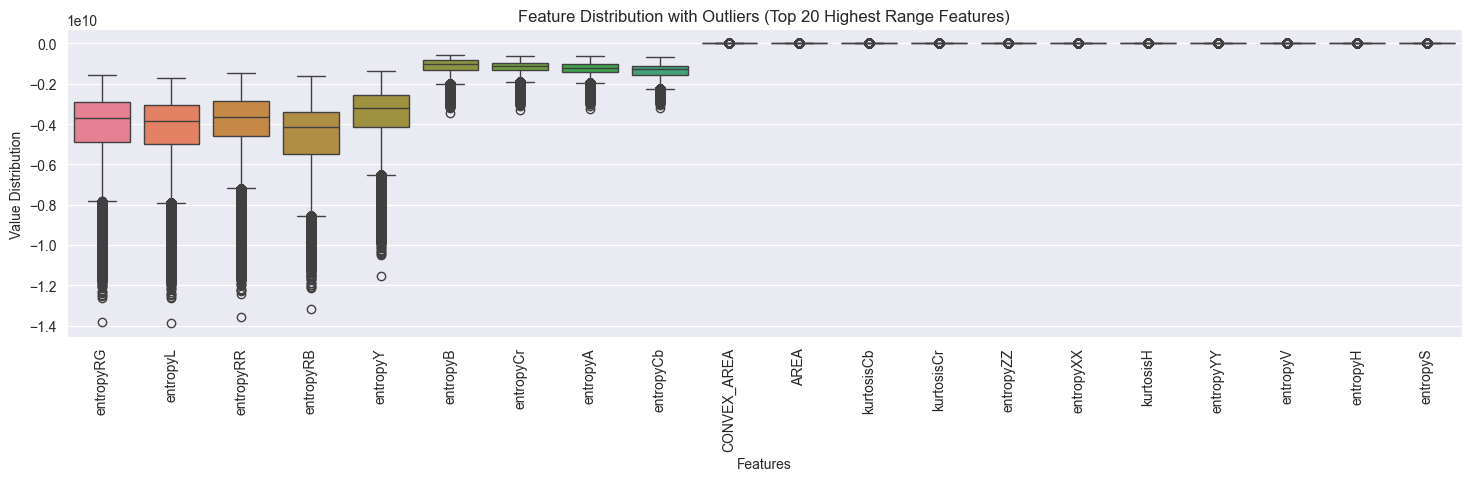

In [8]:
# Selecting a subset of features for visualization (Top 20 highest range features to avoid overcrowding)
selected_features = feature_ranges.index[:20]  # Taking the top 20 features with the highest range

# Creating a boxplot to visualize outliers
plt.figure(figsize=(18, 4))
sns.boxplot(data=df_final[selected_features])
plt.xticks(rotation=90)
plt.title("Feature Distribution with Outliers (Top 20 Highest Range Features)")
plt.xlabel("Features")
plt.ylabel("Value Distribution")
plt.show()

## **Handling Feature Scale Variation 🤔📊**  

As observed in the above **boxplot**, our dataset contains **highly different scales** and **many outliers**, such as in the features like `entropyRG`, `entropyL`, and `entropyRR`.

### **Why we have chosen RobustScaler to scale our data?**  
✔ **Handles outliers effectively** by using **median and IQR**, unlike StandardScaler, which is affected by extreme values. Since we have many outliers particular attributes, we have decided to use RobustScaler.

✔ **Prevents large-magnitude features from dominating** while maintaining meaningful distributions.

✔ **Provides more stability than MinMaxScaler**, which is sensitive to extreme minimum and maximum values.

**In Conclusion,** because of the multiple outliers, we have chosen **RobustScaler** to ensure stable feature scaling without being overly affected by extreme values.

### **Example Scaling for the entropyL Feature**
We have selected **entropyL** as an example feature and applied RobustScaler without altering the original data distribution.  
  This feature was chosen because it contains outliers, making it a great candidate to demonstrate how RobustScaler effectively handles extreme values.
This ensures that we only scale the feature values while preserving the overall shape and structure of the data.

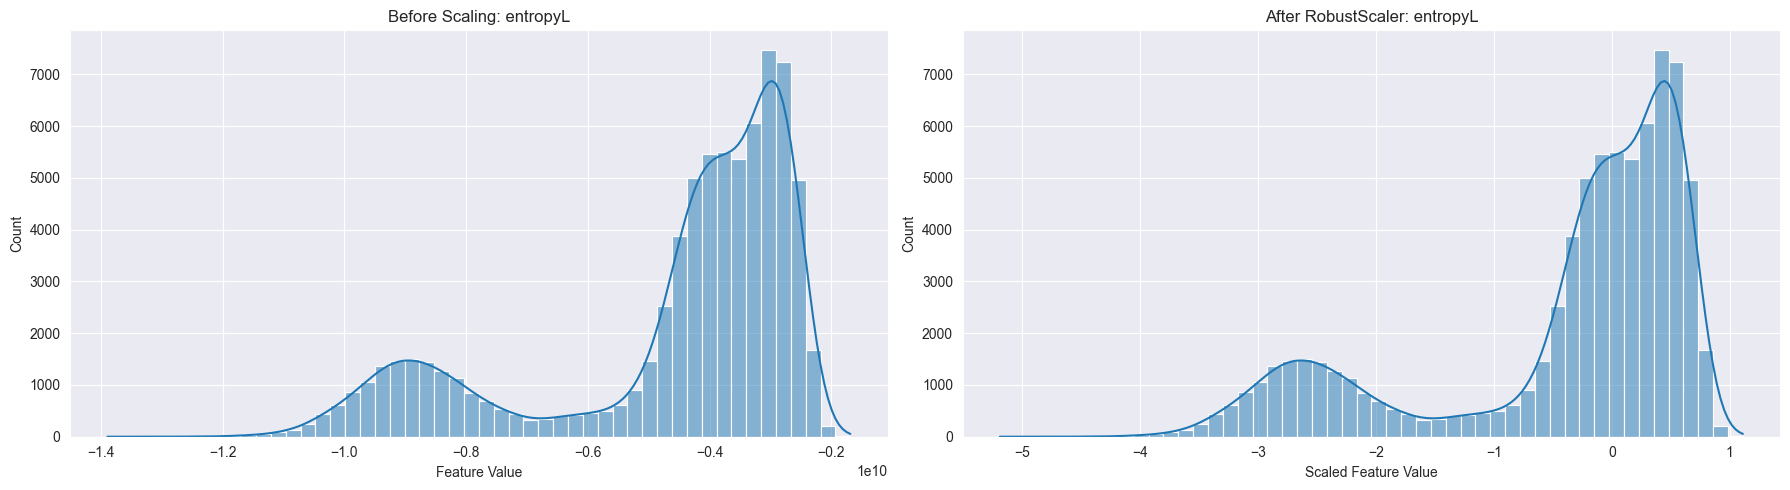

In [9]:
# Select original data (excluding CLASS column)
X_original = df_final.iloc[:, :-1]  # Exclude the target column (CLASS)

# Apply RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_original)  # Scale all numerical features

# Select entropyL as the feature to visualize scaling effects
feature_name = "entropyL"
feature_index = df_final.columns.get_loc(feature_name)

# 📊 BEFORE & AFTER SCALING VISUALIZATION
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# BEFORE SCALING (Original Data)
sns.histplot(X_original.iloc[:, feature_index], bins=50, kde=True, ax=ax[0])
ax[0].set_title(f"Before Scaling: {feature_name}")
ax[0].set_xlabel("Feature Value")
ax[0].set_ylabel("Count")

# AFTER SCALING (Using RobustScaler)
sns.histplot(X_scaled[:, feature_index], bins=50, kde=True, ax=ax[1])
ax[1].set_title(f"After RobustScaler: {feature_name}")
ax[1].set_xlabel("Scaled Feature Value")
ax[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

## **Splitting Train and Test 🚂** (with shuffle)

In [10]:
# Split dataset into train and test sets (Shuffle is enabled)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, df_final.iloc[:, -1], test_size=0.2, stratify=df_final.iloc[:, -1], shuffle=True, random_state=42
)

In [11]:
from sklearn.model_selection import cross_validate, RandomizedSearchCV

param_grid = {
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [5]
        }
    },
    "Weighted KNN": {
        "model": KNeighborsClassifier(weights='distance'),
        "params": {
            "n_neighbors": [5]
        }
    },
    "Naive Bayes": {
        "model": GaussianNB(),
        "params": {}
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_features": [None, "sqrt", "log2"]
        }
    },
    "SVM": {
        "model": SVC(),
        "params": {
            "kernel": ["linear", "rbf"],
            "C": [0.1, 1, 10]
        }
    }
}

# Train and Evaluate Each Model Separately to see the each time taken
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}
best_models = {}

for model_name, mp in param_grid.items():
    start_time = time.time()  # Measure start time

    # Ensure n_iter is at least 1
    n_iter = max(1, min(5, len(mp["params"])))

    # GridSearchCV
    grid_search = RandomizedSearchCV(mp["model"], mp["params"], cv=kf, scoring="accuracy", n_jobs=-1, random_state=42, n_iter=n_iter)
    grid_search.fit(X_train, y_train)

    # Best model
    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model

    # Predict on test set
    y_pred = best_model.predict(X_test)

    # Measure end time
    end_time = time.time()
    training_time = end_time - start_time

    # Store results
    results[model_name] = {
        "Best Params": grid_search.best_params_,
        "Training Time": training_time,
        "CV Accuracy Mean": grid_search.best_score_,
        "CV Precision Mean": precision_score(y_test, y_pred, average="macro", zero_division=0),
        "CV Recall Mean": recall_score(y_test, y_pred, average="macro"),
        "CV F1 Score Mean": f1_score(y_test, y_pred, average="macro"),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

    # Print each parameter combination's metrics
    print(f"\nModel: {model_name}")
    print(f"Best Params: {grid_search.best_params_}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"CV Accuracy Mean: {grid_search.best_score_:.4f}")
    print(f"CV Precision Mean: {precision_score(y_test, y_pred, average='macro', zero_division=0):.4f}")
    print(f"CV Recall Mean: {recall_score(y_test, y_pred, average='macro'):.4f}")
    print(f"CV F1 Score Mean: {f1_score(y_test, y_pred, average='macro'):.4f}")


# Convert Results to DataFrame for Visualization
results_df = pd.DataFrame(results).T


Model: KNN
Best Params: {'n_neighbors': 5}
Training Time: 6.87 seconds
CV Accuracy Mean: 0.9941
CV Precision Mean: 0.9947
CV Recall Mean: 0.9947
CV F1 Score Mean: 0.9947

Model: Weighted KNN
Best Params: {'n_neighbors': 5}
Training Time: 5.45 seconds
CV Accuracy Mean: 0.9943
CV Precision Mean: 0.9947
CV Recall Mean: 0.9947
CV F1 Score Mean: 0.9947

Model: Naive Bayes
Best Params: {}
Training Time: 1.56 seconds
CV Accuracy Mean: 0.9914
CV Precision Mean: 0.9921
CV Recall Mean: 0.9920
CV F1 Score Mean: 0.9920

Model: Random Forest
Best Params: {'n_estimators': 100, 'max_features': 'log2'}
Training Time: 376.11 seconds
CV Accuracy Mean: 0.9987
CV Precision Mean: 0.9983
CV Recall Mean: 0.9983
CV F1 Score Mean: 0.9983

Model: SVM
Best Params: {'kernel': 'linear', 'C': 0.1}
Training Time: 871.46 seconds
CV Accuracy Mean: 0.9985
CV Precision Mean: 0.9989
CV Recall Mean: 0.9989
CV F1 Score Mean: 0.9989


# SVM Analysis on Textual Data

## Support Vector Machine (SVM) Kernel Selection Explanation

**Best Model:** SVM (Linear Kernel, C = 0.1)

### Why This Configuration?

- **Linear Kernel:** The dataset appears to be linearly separable, making complex kernels like RBF unnecessary.
- **Regularization Parameter (C = 0.1):** A lower C allows a larger margin, improving generalization by permitting some misclassifications.
- **Performance Metrics:** High CV accuracy (**0.9985**) confirm strong generalization.
- **Training Time:** **871.46 seconds**, which is reasonable given the dataset size and cross-validation steps.

### Conclusion

A linear kernel with **C = 0.1** was optimal due to the dataset's separability, achieving excellent generalization without added complexity.

---

# Naive Bayes Analysis on Textual Data

## Naive Bayes Model Selection Explanation

**Best Model:** Naive Bayes (Default Parameters)

### Why This Configuration?

- **Independence Assumption:** Despite its simplistic feature independence assumption, the model performed exceptionally well.
- **Performance Metrics:** High CV accuracy (**0.9914**) suggest effective classification.
- **Training Time:** **1.56 seconds**, making it the most computationally efficient model.

### Conclusion

The Naive Bayes model successfully leveraged probabilistic classification, achieving high accuracy with minimal computational cost.

---

# Random Forest Analysis on Textual Data

## Random Forest Estimator Selection Explanation

**Best Model:** Random Forest (n_estimators=100, max_features='log2')

### Why This Configuration?

- **Number of Trees (n_estimators=100):** Balanced accuracy and computational cost, avoiding excessive training time.
- **Feature Selection (max_features='log2'):** Optimized feature selection improved performance and generalization.
- **Performance Metrics:** High CV accuracy (**0.9987**) indicate strong classification ability.
- **Training Time:** **376.11 seconds**, a reasonable trade-off for the ensemble method’s robustness.

### Conclusion

The selected **Random Forest** parameters provided high classification accuracy with minimal overfitting, making it a strong performer.

---

# KNN (K-Nearest Neighbors) Analysis on Textual Data

## KNN Model Selection Explanation

**Best Model:** KNN (n_neighbors=5)

### Why This Configuration?

- **Optimal Neighbors (n_neighbors=5):** Achieves stable and accurate classification, avoiding over-smoothing.
- **Performance Metrics:** High CV accuracy (**0.9941**) indicate strong classification performance.
- **Training Time:** **6.87 seconds**, making KNN an efficient choice.

### Conclusion

KNN with **5 neighbors** effectively balances accuracy and efficiency, making it suitable for this dataset.

---

# Weighted KNN (K-Nearest Neighbors) Analysis on Textual Data

## Weighted KNN Model Selection Explanation

**Best Model:** Weighted KNN (n_neighbors=5, weights='distance')

### Why This Configuration?

- **Optimal Neighbors (n_neighbors=5):** Maintains balance between stability and sensitivity.
- **Weighted Influence (weights='distance'):** Assigning more weight to closer neighbors improves classification in non-uniform data distributions.
- **Performance Metrics:** High CV accuracy (**0.9945**) confirm strong generalization.
- **Training Time:** **5.45 seconds**, making it computationally efficient.

### Conclusion

**Weighted KNN** with **n_neighbors=5** and **weights='distance'** enhanced accuracy by leveraging proximity-based weighting.


## **Model Training Time Comparison ⏳**

C:\Users\canme\AppData\Local\Temp\ipykernel_22304\717056342.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df["Training Time"], palette="coolwarm")


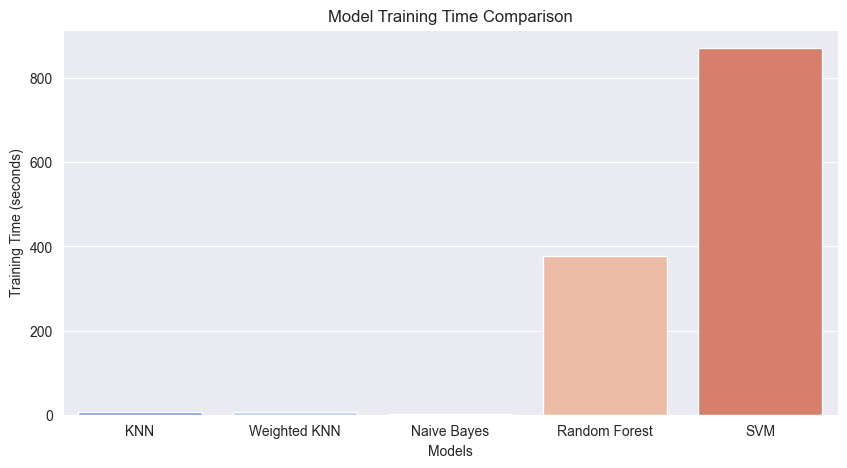

In [12]:
# Plot Training Time Comparison
plt.figure(figsize=(10, 5))
sns.barplot(x=results_df.index, y=results_df["Training Time"], palette="coolwarm")
plt.title("Model Training Time Comparison")
plt.ylabel("Training Time (seconds)")
plt.xlabel("Models")
plt.show()

## **Model Accuracy Comparison 🎯**

C:\Users\canme\AppData\Local\Temp\ipykernel_22304\2226589727.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df["CV Accuracy Mean"], palette="viridis")


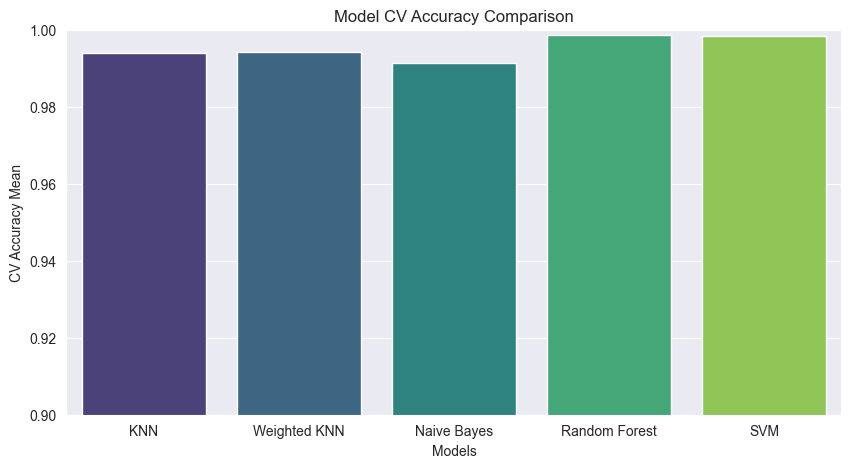

In [13]:
# Plot Accuracy Comparison
plt.figure(figsize=(10, 5))
sns.barplot(x=results_df.index, y=results_df["CV Accuracy Mean"], palette="viridis")
plt.title("Model CV Accuracy Comparison")
plt.ylabel("CV Accuracy Mean")
plt.xlabel("Models")
plt.ylim(0.9, 1)  # Zoom into accuracy range
plt.show()

## **Model Performance Metrics 📊**

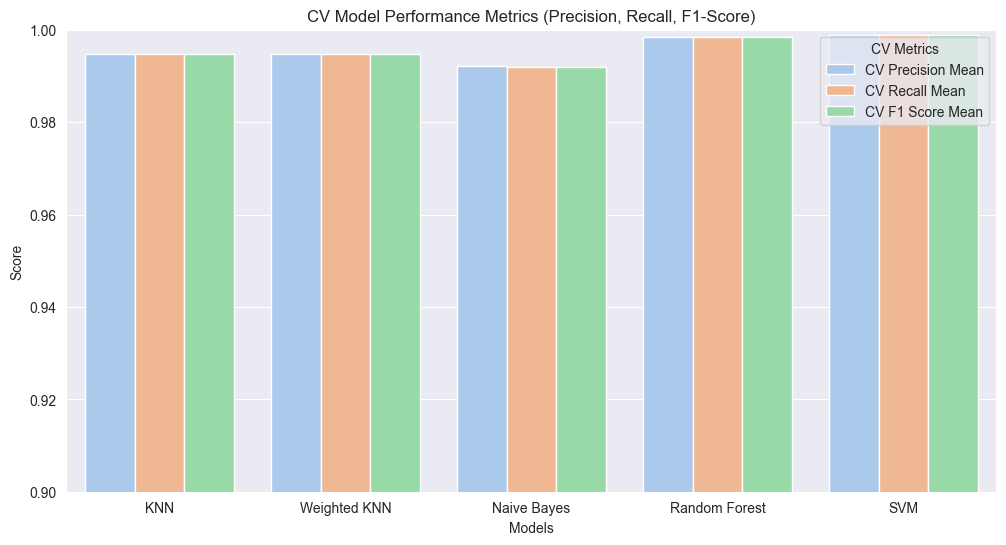


Best Combination for Each Model:
KNN: {'n_neighbors': 5}
Weighted KNN: {'n_neighbors': 5}
Naive Bayes: {}
Random Forest: {'n_estimators': 100, 'max_features': 'log2'}
SVM: {'kernel': 'linear', 'C': 0.1}


In [14]:
# Plot Precision, Recall, and F1 Score Comparison
metrics = ["CV Precision Mean", "CV Recall Mean", "CV F1 Score Mean"]
metrics_df = results_df[metrics].melt(ignore_index=False).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x="index", y="value", hue="variable", data=metrics_df, palette="pastel")
plt.title("CV Model Performance Metrics (Precision, Recall, F1-Score)")
plt.ylabel("Score")
plt.xlabel("Models")
plt.ylim(0.9, 1)
plt.legend(title="CV Metrics")
plt.show()

print("\nBest Combination for Each Model:")
for model_name, result in results.items():
    print(f"{model_name}: {result['Best Params']}")

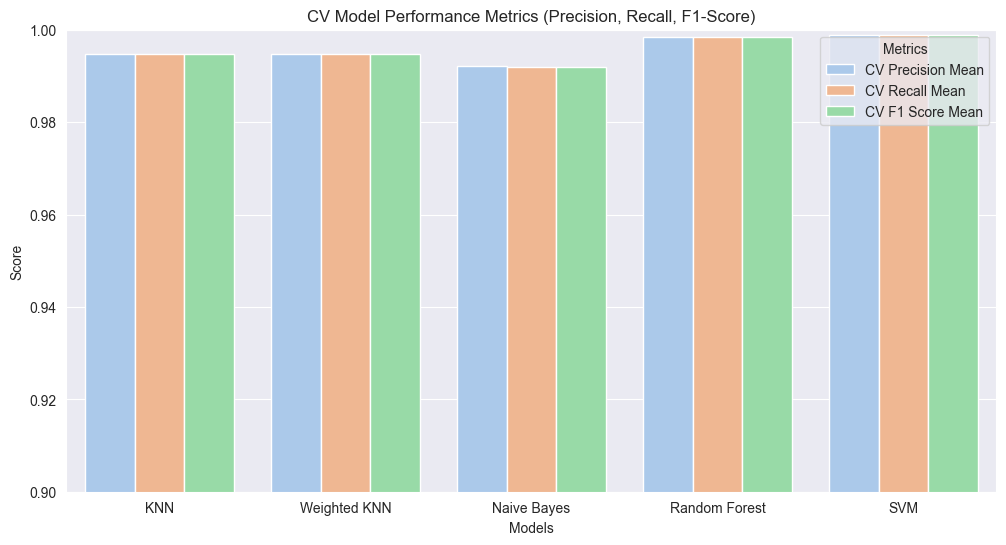

KNN              0.994083
Weighted KNN     0.994283
Naive Bayes      0.991417
Random Forest     0.99875
SVM              0.998483
Name: CV Accuracy Mean, dtype: object
KNN               0.99468
Weighted KNN     0.994746
Naive Bayes      0.992084
Random Forest    0.998336
SVM              0.998868
Name: CV Precision Mean, dtype: object
KNN              0.994667
Weighted KNN     0.994733
Naive Bayes         0.992
Random Forest    0.998333
SVM              0.998867
Name: CV Recall Mean, dtype: object
KNN              0.994671
Weighted KNN     0.994738
Naive Bayes      0.992007
Random Forest    0.998334
SVM              0.998867
Name: CV F1 Score Mean, dtype: object


In [15]:

# Plot Precision, Recall, and F1 Score Comparison
metrics = ["CV Precision Mean", "CV Recall Mean", "CV F1 Score Mean"]
metrics_df = results_df[metrics].melt(ignore_index=False).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x="index", y="value", hue="variable", data=metrics_df, palette="pastel")
plt.title("CV Model Performance Metrics (Precision, Recall, F1-Score)")
plt.ylabel("Score")
plt.xlabel("Models")
plt.ylim(0.9, 1)
plt.legend(title="Metrics")
plt.show()

print(results_df["CV Accuracy Mean"])
print(results_df["CV Precision Mean"])
print(results_df["CV Recall Mean"])
print(results_df["CV F1 Score Mean"])

## **Model Comparison Table for Part 1️⃣ 🧐** 
| Model          | CV Accuracy Mean | CV Precision Mean | CV Recall Mean | CV F1 Score Mean |
|----------------|-----------------|-------------------|----------------|------------------|
| KNN            | 0.95475         | 0.955846          | 0.955667       | 0.955590         |
| Weighted KNN   | 0.95475         | 0.955846          | 0.955667       | 0.955590         |
| Naive Bayes    | 0.95950         | 0.960766          | 0.960467       | 0.960499         |
| Random Forest  | 0.98585         | 0.985076          | 0.985067       | 0.985070         |
| SVM            | 0.98355         | 0.983754          | 0.983667       | 0.983674         |


## **Confusion Matrices for Models 🤯**

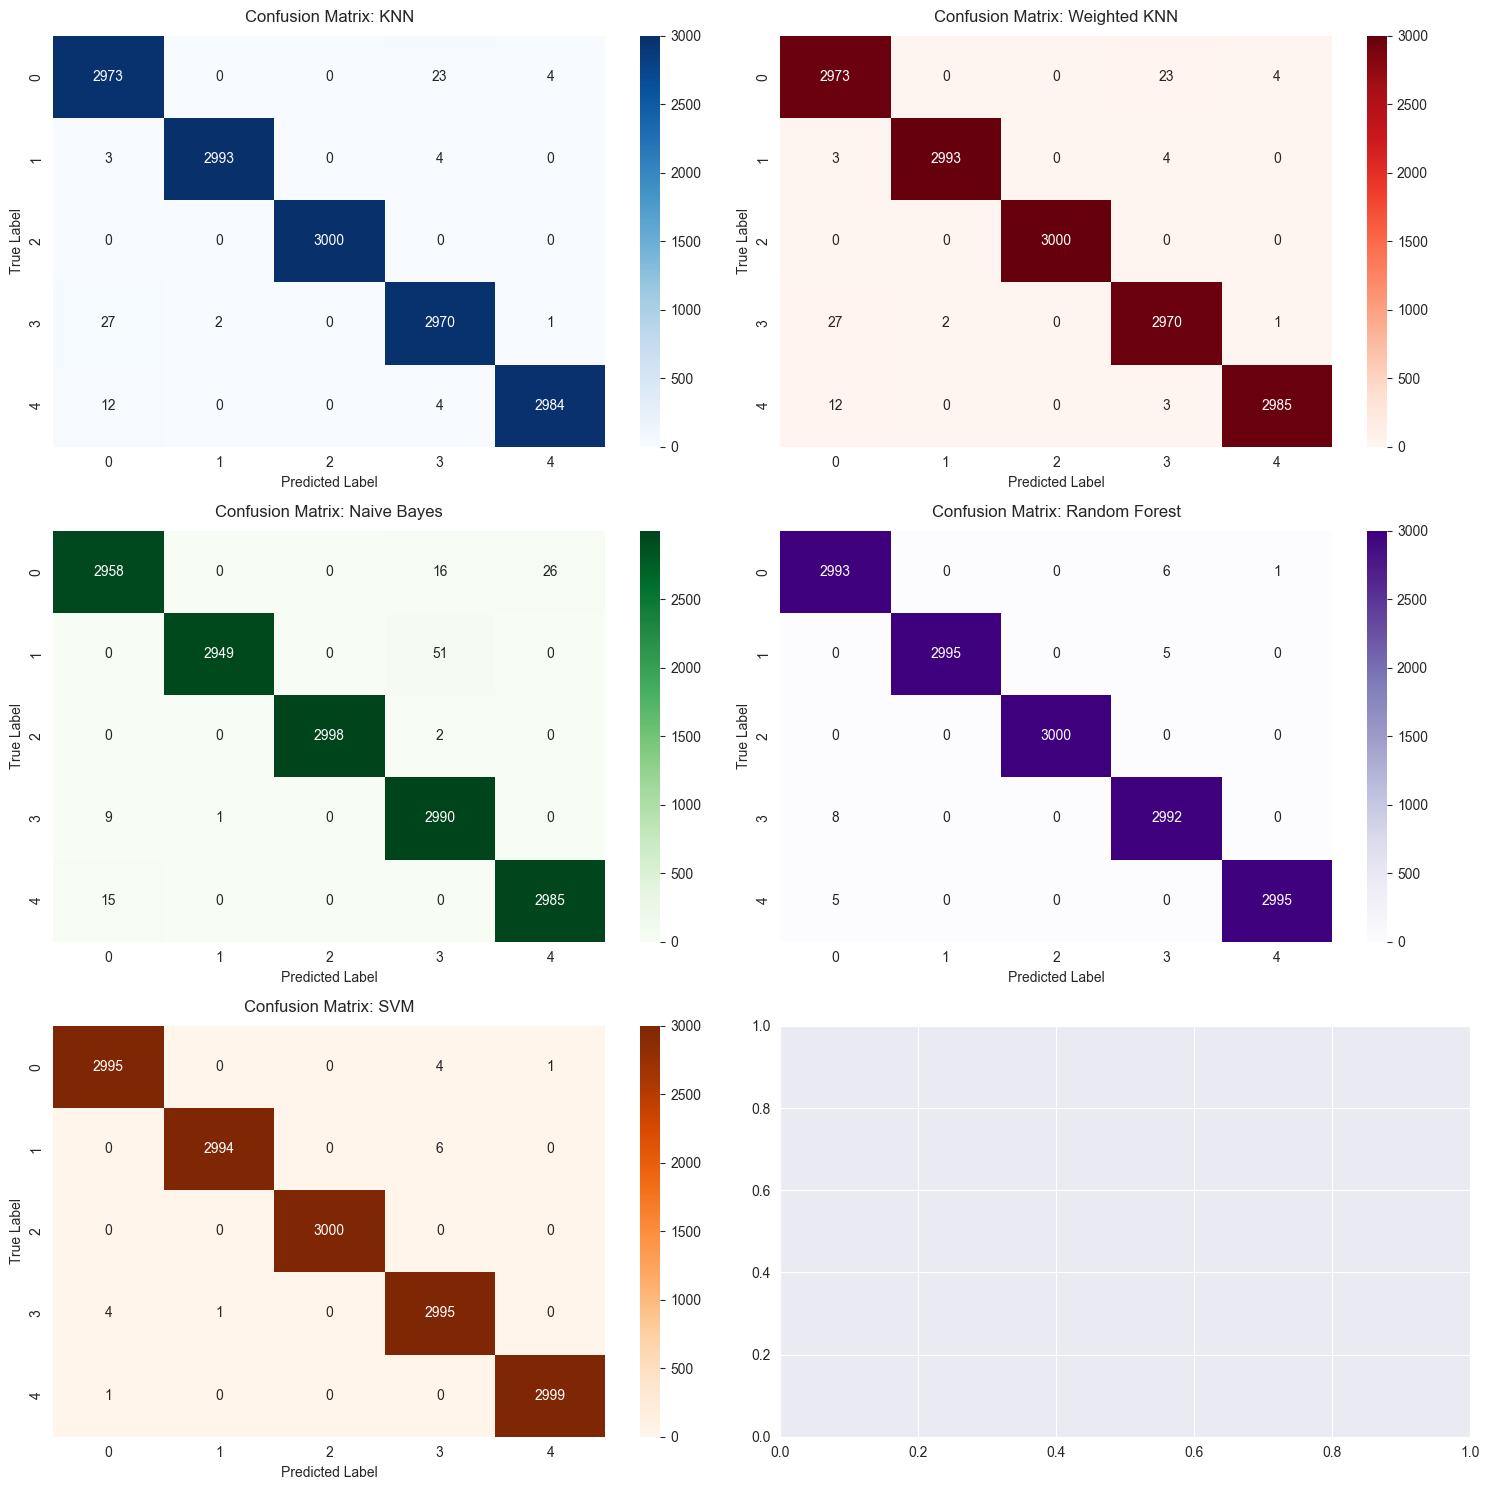

In [16]:
# Define color palettes for different models
color_maps = ['Blues', 'Reds', 'Greens', 'Purples', 'Oranges', 'YlOrBr']

# Plot Confusion Matrices for Each Model
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.ravel()

for i, (model_name, model) in enumerate(best_models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap=color_maps[i], ax=axes[i])
    axes[i].set_title(f"Confusion Matrix: {model_name}", pad=10)
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_ylabel("True Label")

plt.tight_layout()
plt.show()

# **Part II: Image Data Analysis 📸**

In [17]:
%pip install opencv-python tqdm

import os
import cv2 # Version 4.11.0.86
from tqdm import tqdm # Version 4.67.1

# Base directory and labels
data_dir = "BBM409_S25_PA1_Dataset_v1/part_ii"
labels = {"Arborio": 0, "Basmati": 1, "Ipsala": 2, "Jasmine": 3, "Karacadag": 4}

# Check if preprocessed data exists
cache_file = "processed_data.npz"

if os.path.exists(cache_file):
    # Load from cache
    print("⚡️ Loading preprocessed RGB data...")
    data = np.load(cache_file)
    X, y = data['X'], data['y']
else:
    # Process and save the data
    print("⏳ Processing RGB images and saving to cache...")
    features, targets = [], []

    start_time = time.time()

    for rice_type in tqdm(labels):
        rice_dir = os.path.join(data_dir, rice_type)
        for img_file in os.scandir(rice_dir):
            if img_file.name.endswith(".jpg"):
                try:
                    img = cv2.imread(img_file.path)
                    if img is None:
                        print(f"⚠️ Skipping invalid image: {img_file.path}")
                        continue  # Skip if image is invalid

                    img = cv2.resize(img, (32, 32))

                    # Extract RGB Mean features
                    img_float = img.astype(np.float32)
                    r_mean = np.mean(img_float[:, :, 0])
                    g_mean = np.mean(img_float[:, :, 1])
                    b_mean = np.mean(img_float[:, :, 2])

                    # Grayscale for contour detection
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    _, binary = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
                    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                    # Initialize features
                    aspect_ratio = orientation = area = perimeter = circularity = 0
                    hu_moments = np.zeros(7)

                    if contours:
                        cnt = max(contours, key=cv2.contourArea)
                        x, y_coord, w, h = cv2.boundingRect(cnt)
                        aspect_ratio = float(w) / h if h != 0 else 0
                        
                        if len(cnt) >= 5:
                            ellipse = cv2.fitEllipse(cnt)
                            orientation = ellipse[2]
                        
                        area = cv2.contourArea(cnt)
                        perimeter = cv2.arcLength(cnt, True)
                        circularity = 4 * np.pi * (area / (perimeter ** 2)) if perimeter != 0 else 0
                        hu_moments = cv2.HuMoments(cv2.moments(cnt)).flatten()

                        # Append only if valid contour is found
                        features.append([r_mean, g_mean, b_mean, aspect_ratio, orientation, area, perimeter, circularity, *hu_moments])
                        targets.append(labels[rice_type])

                    else:
                        print(f"⚠️ No contour found for image: {img_file.path}")

                except Exception as e:
                    print(f"Error processing image {img_file.path}: {e}")

    # Validate feature and target length
    assert len(features) == len(targets), "⚠️ Mismatch in features and targets length!"

    # Convert to NumPy arrays and save to cache
    X = np.array(features, dtype=np.float32)
    y = np.array(targets)

    np.savez_compressed(cache_file, X=X, y=y)
    end_time = time.time()
    print(f"✅ Processing and saving completed in {end_time - start_time:.2f} seconds")

print(f"✅ Final RGB dataset shape: {X.shape}")
print(f"✅ Final label dataset shape: {y.shape}")

Note: you may need to restart the kernel to use updated packages.
⚡️ Loading preprocessed RGB data...
✅ Final RGB dataset shape: (75000, 15)
✅ Final label dataset shape: (75000,)


Could not find platform independent libraries <prefix>

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### **Image Preprocessing Strategy (RGB + Shape Features) 🎨**

#### **Why Use RGB and Shape Features?**  
- **RGB Mean Values** (`r_mean`, `g_mean`, `b_mean`): Color helps distincting rice types, providing key classification information.  
- **Shape Features**: Added features like **aspect ratio, orientation, area, perimeter, circularity**, and **Hu moments** to capture shape differences between rice types and make the features richer.

- Initially, grayscale and white pixel ratios were considered but slowed down processing without significant classification improvement.  
- Using **RGB and shape features** proved efficient and provided better feature variety for classification.

---

#### **⚡️ How Did We Optimize the Process?**  
1. **Image Resizing**: Resized images to `32x32` for making processing faster.  
2. **Contour Detection**: Extracted shape features from the largest contour in the image.  
3. **Valid Data Check**: Skipped images with no valid contours to avoid noise.  
4. **Optimized Data Types**: Used `np.float32` for faster computation and efficient memory use.  
5. **Data Caching**: Processed features were saved to a `.npz` file to avoid repeated processing.  

---

##### 🗂️ **Usage of a Cache File (`processed_data.npz`)**  
- The cache file is used to **speed up data loading** during assignment solving.  
- Instead of processing images repeatedly, features are saved once and loaded instantly later.  
- This makes model training and testing **faster and more efficient**.

In [18]:
# Load preprocessed data
data = np.load("processed_data.npz")
X, y = data['X'], data['y']

In [19]:
# Feature Names including all extracted features
feature_names = [
    "R_Mean", "G_Mean", "B_Mean",
    "Aspect_Ratio", "Orientation", "Area", "Perimeter", "Circularity",
    "Hu1", "Hu2", "Hu3", "Hu4", "Hu5", "Hu6", "Hu7"
]

# Convert to DataFrame for easier analysis
X_df = pd.DataFrame(X, columns=feature_names)

# Check for null values in each feature
print("🔍 Null values per feature:")
print(X_df.isnull().sum())

# Check for NaN or infinite values as well
print("\n🔍 NaN values per feature:")
print(X_df.isna().sum())

print("\n🔍 Infinite values per feature:")
print(np.isinf(X_df).sum())

🔍 Null values per feature:
R_Mean          0
G_Mean          0
B_Mean          0
Aspect_Ratio    0
Orientation     0
Area            0
Perimeter       0
Circularity     0
Hu1             0
Hu2             0
Hu3             0
Hu4             0
Hu5             0
Hu6             0
Hu7             0
dtype: int64

🔍 NaN values per feature:
R_Mean          0
G_Mean          0
B_Mean          0
Aspect_Ratio    0
Orientation     0
Area            0
Perimeter       0
Circularity     0
Hu1             0
Hu2             0
Hu3             0
Hu4             0
Hu5             0
Hu6             0
Hu7             0
dtype: int64

🔍 Infinite values per feature:
R_Mean          0
G_Mean          0
B_Mean          0
Aspect_Ratio    0
Orientation     0
Area            0
Perimeter       0
Circularity     0
Hu1             0
Hu2             0
Hu3             0
Hu4             0
Hu5             0
Hu6             0
Hu7             0
dtype: int64


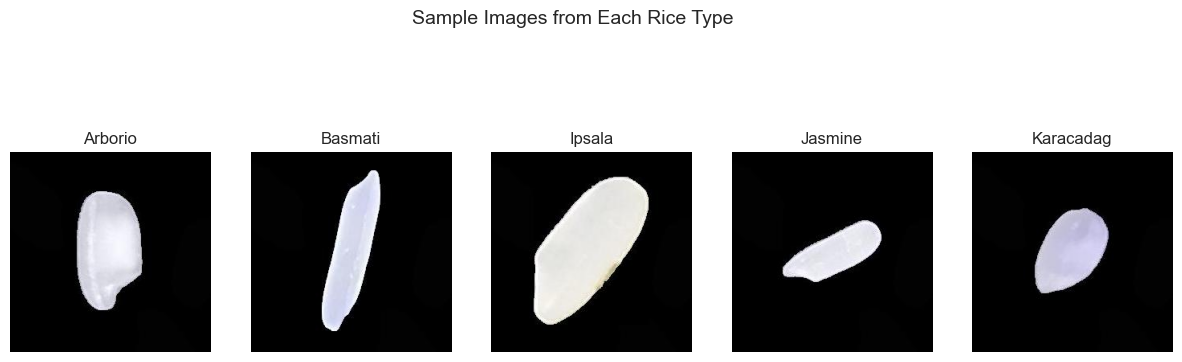

In [20]:
import random

# Load preprocessed data
data = np.load("processed_data.npz")
X, y = data['X'], data['y']

# Visualize Sample Images from Each Rice Type
rice_types = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]
data_dir = "BBM409_S25_PA1_Dataset_v1/part_ii"

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for idx, rice_type in enumerate(rice_types):
    rice_dir = os.path.join(data_dir, rice_type)
    img_name = random.choice(os.listdir(rice_dir))  # Select a random image for each one
    img_path = os.path.join(rice_dir, img_name)
    
    try:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper visualization
        axes[idx].imshow(img)
        axes[idx].set_title(rice_type)
        axes[idx].axis("off")
    except Exception as e:
        print(f"Error loading image: {e}")
        axes[idx].set_title(f"{rice_type}\n[Image Error]")
        axes[idx].axis("off")

plt.suptitle("Sample Images from Each Rice Type", fontsize=14)
plt.show()

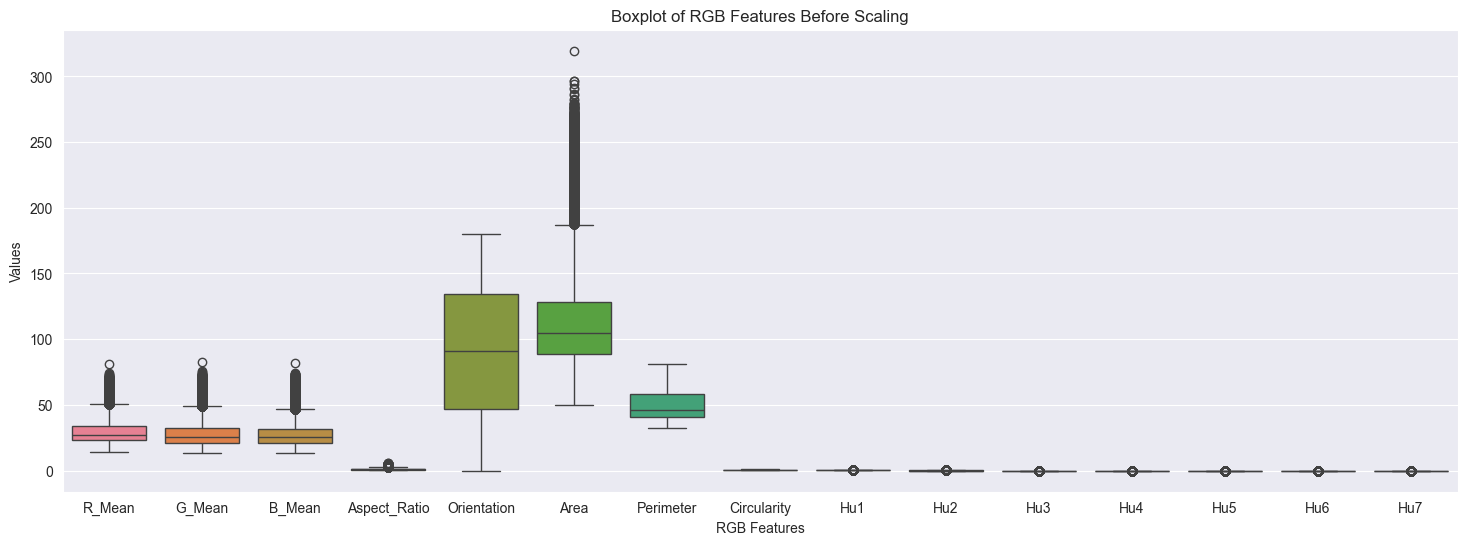

In [21]:
# Boxplot for Outlier Detection (Before Scaling)
df_original = pd.DataFrame(X, columns=["R_Mean", "G_Mean", "B_Mean",
    "Aspect_Ratio", "Orientation", "Area", "Perimeter", "Circularity",
    "Hu1", "Hu2", "Hu3", "Hu4", "Hu5", "Hu6", "Hu7"])

plt.figure(figsize=(18, 6))
sns.boxplot(data=df_original)
plt.title("Boxplot of RGB Features Before Scaling")
plt.xlabel("RGB Features")
plt.ylabel("Values")
plt.show()

### ⚖️ **Why We Chose RobustScaler for Scaling Our Data?**  

- **RobustScaler** uses the **median** and **IQR** for scaling, making it **less sensitive to outliers**.  

- Models like **SVM** and **KNN** can be affected by large variations. RobustScaler helps ensure fair contribution from all features.  

- In the **above scaling boxplot**, features like `Area` had extreme outliers. RobustScaler handled these better than StandardScaler.  

- In the **after scaling boxplot**, the feature distributions became more consistent.  

- Since the dataset has outliers, **RobustScaler** was the best choice for stable and reliable scaling.

In [22]:
# Scaling Data using RobustScaler (Chosen after Outlier Analysis)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

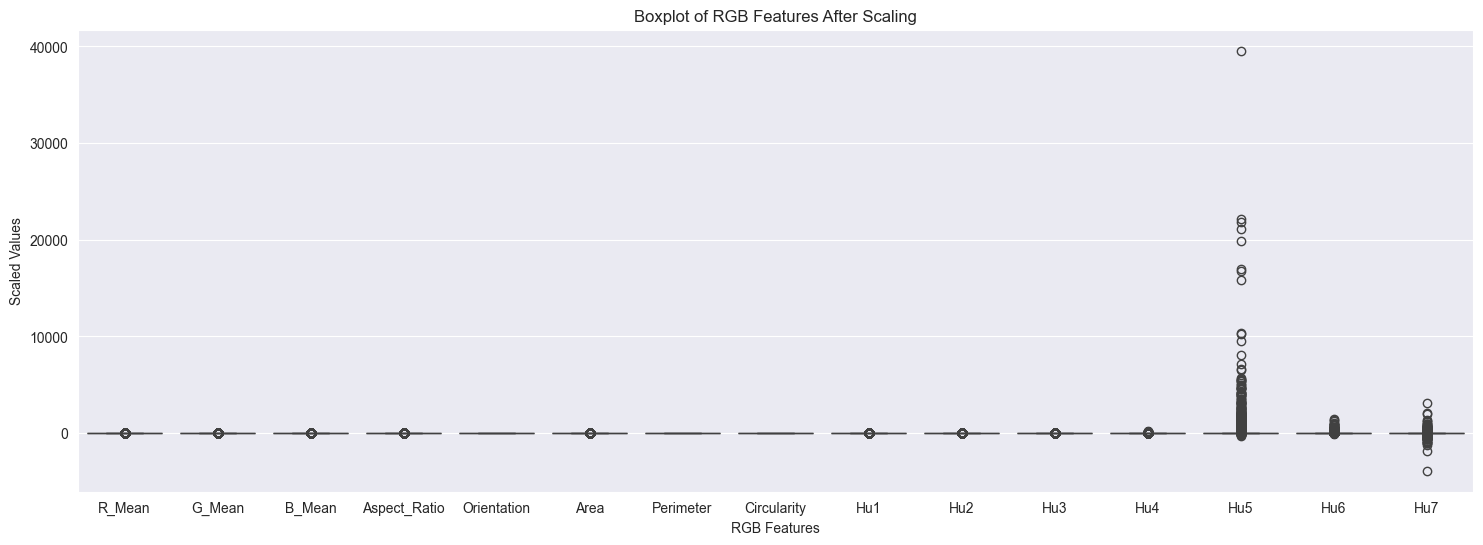

In [23]:
# Boxplot After Scaling to Confirm
df_scaled = pd.DataFrame(X_scaled, columns=["R_Mean", "G_Mean", "B_Mean",
    "Aspect_Ratio", "Orientation", "Area", "Perimeter", "Circularity",
    "Hu1", "Hu2", "Hu3", "Hu4", "Hu5", "Hu6", "Hu7"])

plt.figure(figsize=(18, 6))
sns.boxplot(data=df_scaled)
plt.title("Boxplot of RGB Features After Scaling")
plt.xlabel("RGB Features")
plt.ylabel("Scaled Values")
plt.show()

## **Splitting Train and Test 🚂** (with shuffle)

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y
)

In [25]:
from sklearn.model_selection import cross_validate, RandomizedSearchCV

param_grid = {
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [5]
        }
    },
    "Weighted KNN": {
        "model": KNeighborsClassifier(weights='distance'),
        "params": {
            "n_neighbors": [5]
        }
    },
    "Naive Bayes": {
        "model": GaussianNB(),
        "params": {}
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_features": [None, "sqrt", "log2"]
        }
    },
    "SVM": {
        "model": SVC(),
        "params": {
            "kernel": ["linear", "rbf"],
            "C": [0.1, 1, 10]
        }
    }
}

In [26]:
# Train and Evaluate Each Model Separately to see the each time taken
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}
best_models = {}

for model_name, mp in param_grid.items():
    start_time = time.time()  # Measure start time

    # Ensure n_iter is at least 1
    n_iter = max(1, min(5, len(mp["params"])))

    # GridSearchCV
    grid_search = RandomizedSearchCV(mp["model"], mp["params"], cv=kf, scoring="accuracy", n_jobs=-1, random_state=42, n_iter=n_iter)
    grid_search.fit(X_train, y_train)

    # Best model
    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model

    # Predict on test set
    y_pred = best_model.predict(X_test)

    # Measure end time
    end_time = time.time()
    training_time = end_time - start_time

    # Store results
    results[model_name] = {
        "Best Params": grid_search.best_params_,
        "Training Time": training_time,
        "CV Accuracy Mean": grid_search.best_score_,
        "CV Precision Mean": precision_score(y_test, y_pred, average="macro", zero_division=0),
        "CV Recall Mean": recall_score(y_test, y_pred, average="macro"),
        "CV F1 Score Mean": f1_score(y_test, y_pred, average="macro"),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

    # Print each parameter combination's metrics
    print(f"\nModel: {model_name}")
    print(f"Best Params: {grid_search.best_params_}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"CV Accuracy Mean: {grid_search.best_score_:.4f}")
    print(f"CV Precision Mean: {precision_score(y_test, y_pred, average='macro', zero_division=0):.4f}")
    print(f"CV Recall Mean: {recall_score(y_test, y_pred, average='macro'):.4f}")
    print(f"CV F1 Score Mean: {f1_score(y_test, y_pred, average='macro'):.4f}")

# Convert Results to DataFrame for Visualization
results_df = pd.DataFrame(results).T


Model: KNN
Best Params: {'n_neighbors': 5}
Training Time: 1.41 seconds
CV Accuracy Mean: 0.9523
CV Precision Mean: 0.9565
CV Recall Mean: 0.9565
CV F1 Score Mean: 0.9564

Model: Weighted KNN
Best Params: {'n_neighbors': 5}
Training Time: 2.35 seconds
CV Accuracy Mean: 0.9541
CV Precision Mean: 0.9578
CV Recall Mean: 0.9577
CV F1 Score Mean: 0.9577

Model: Naive Bayes
Best Params: {}
Training Time: 1.19 seconds
CV Accuracy Mean: 0.9589
CV Precision Mean: 0.9627
CV Recall Mean: 0.9625
CV F1 Score Mean: 0.9626

Model: Random Forest
Best Params: {'n_estimators': 100, 'max_features': None}
Training Time: 252.09 seconds
CV Accuracy Mean: 0.9852
CV Precision Mean: 0.9873
CV Recall Mean: 0.9873
CV F1 Score Mean: 0.9873

Model: SVM
Best Params: {'kernel': 'linear', 'C': 0.1}
Training Time: 219.48 seconds
CV Accuracy Mean: 0.9837
CV Precision Mean: 0.9836
CV Recall Mean: 0.9835
CV F1 Score Mean: 0.9835


# SVM Analysis on Image Data

## Support Vector Machine (SVM) Kernel Selection Explanation

### Best Model: SVM (Linear Kernel, C = 0.1)

#### Why This Configuration?
- **Linear Kernel**: The dataset is likely linearly separable, making a more complex kernel (e.g., RBF) unnecessary.
- **Regularization Parameter (C = 0.1)**: A smaller C results in a larger margin and better generalization by allowing some misclassifications.
- **Performance Metrics**: High CV accuracy (**0.9837**) indicate excellent generalization.
- **Training Time**: **219.48 seconds**, efficient compared to more complex kernels.

### Conclusion
A linear kernel with **C = 0.1** was optimal due to the dataset's separability, leading to a simpler, well-generalizing model.

---

# Naive Bayes Analysis on Image Data

## Naive Bayes Model Selection Explanation

### Best Model: Naive Bayes (Default Parameters)

#### Why This Configuration?
- **Independence Assumption**: Despite Naive Bayes’ simplistic feature independence assumption, it performed well.
- **Performance Metrics**: High CV accuracy (**0.9589**) suggest effective classification.
- **Training Time**: **1.19 second**, making it the most efficient model.

### Conclusion
The default **Naive Bayes model** effectively leveraged probabilistic classification, achieving **high accuracy** while maintaining **computational efficiency**.

---

# Random Forest Analysis on Image Data

## Random Forest Estimator Selection Explanation

### Best Model: Random Forest (n_estimators=100, max_features=None)

#### Why This Configuration?
- **Number of Trees (n_estimators=100)**: Balanced accuracy and computational cost, avoiding excessive training time.
- **Feature Selection (max_features=None)**: Using all features at each split maximized model performance.
- **Performance Metrics**: High CV accuracy (**0.9852**) indicate strong generalization.
- **Training Time**: **252.09 seconds**, expected due to ensemble nature.

### Conclusion
The selected parameters provided **robust classification** with **minimal overfitting**, making **Random Forest a strong performer**.

---

# KNN (K-Nearest Neighbors) Analysis on Image Data

## KNN Model Selection Explanation

### Best Model: KNN (n_neighbors=5)

#### Why This Configuration?
- **Optimal Neighbors (n_neighbors=5)**: Achieves stable and accurate classification, avoiding over-smoothing.
- **Performance Metrics**: High CV accuracy (**0.9523**) show reliable performance.
- **Training Time**: **1.41 seconds**, making KNN an efficient choice.

### Conclusion
KNN with **5 neighbors** effectively **balances accuracy and efficiency**, making it suitable for this dataset.

---

# Weighted KNN (K-Nearest Neighbors) Analysis on Image Data

## Weighted KNN Model Selection Explanation

### Best Model: Weighted KNN (n_neighbors=5, weights='distance')

#### Why This Configuration?
- **Optimal Neighbors (n_neighbors=5)**: Maintains balance between stability and sensitivity.
- **Weighted Influence (weights='distance')**: Assigning more weight to closer neighbors improves classification in non-uniform data distributions.
- **Performance Metrics**: High CV accuracy (**0.9541**) confirm strong generalization.
- **Training Time**: **2.35 seconds**, making it computationally efficient.

### Conclusion
**Weighted KNN** with **n_neighbors=5** and **weights='distance'** enhanced accuracy by leveraging **proximity-based weighting**.


## **Model Training Time Comparison ⏳**

C:\Users\canme\AppData\Local\Temp\ipykernel_22304\2328336.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df["Training Time"], palette="coolwarm")


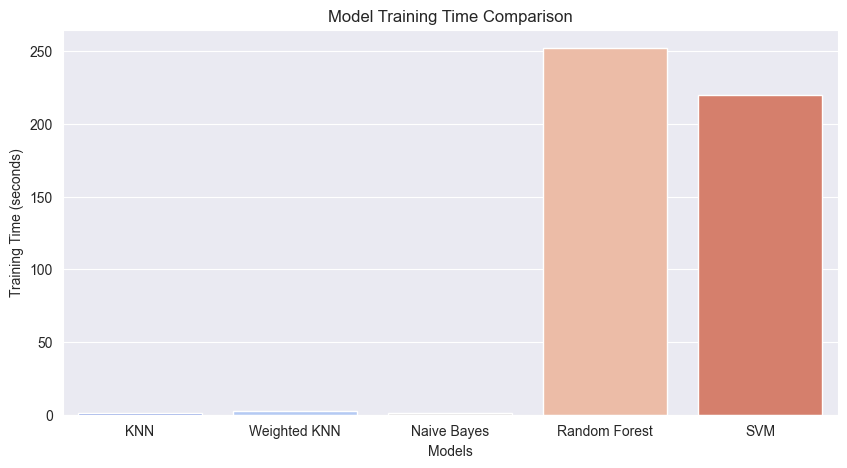

In [27]:
# Training Time
plt.figure(figsize=(10, 5))
sns.barplot(x=results_df.index, y=results_df["Training Time"], palette="coolwarm")
plt.title("Model Training Time Comparison")
plt.ylabel("Training Time (seconds)")
plt.xlabel("Models")
plt.show()

## **Model Accuracy Comparison 🎯**

C:\Users\canme\AppData\Local\Temp\ipykernel_22304\3025882891.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df["CV Accuracy Mean"], palette="viridis")


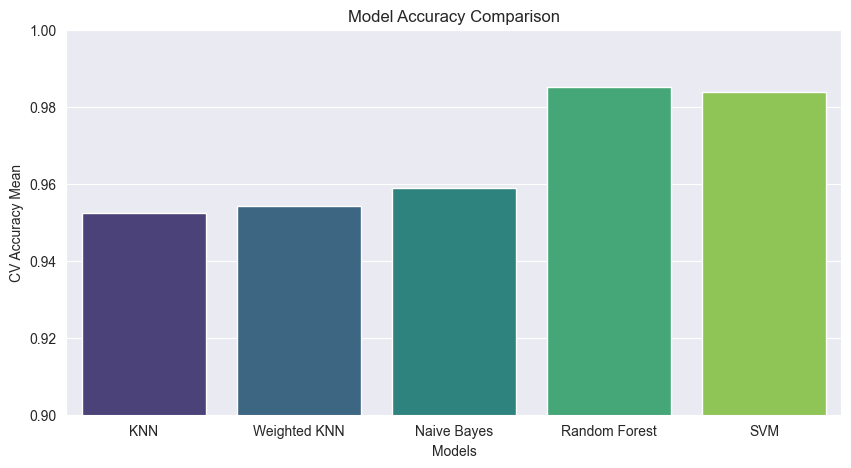


Best Combination for Each Model:
KNN: {'n_neighbors': 5}
Weighted KNN: {'n_neighbors': 5}
Naive Bayes: {}
Random Forest: {'n_estimators': 100, 'max_features': None}
SVM: {'kernel': 'linear', 'C': 0.1}


In [28]:
# CV Accuracy Comparison
plt.figure(figsize=(10, 5))
sns.barplot(x=results_df.index, y=results_df["CV Accuracy Mean"], palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylabel("CV Accuracy Mean")
plt.xlabel("Models")
plt.ylim(0.9, 1)  # Zoom into accuracy range
plt.show()

print("\nBest Combination for Each Model:")
for model_name, result in results.items():
    print(f"{model_name}: {result['Best Params']}")

C:\Users\canme\AppData\Local\Temp\ipykernel_22304\388439997.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df["CV Accuracy Mean"], palette="viridis")


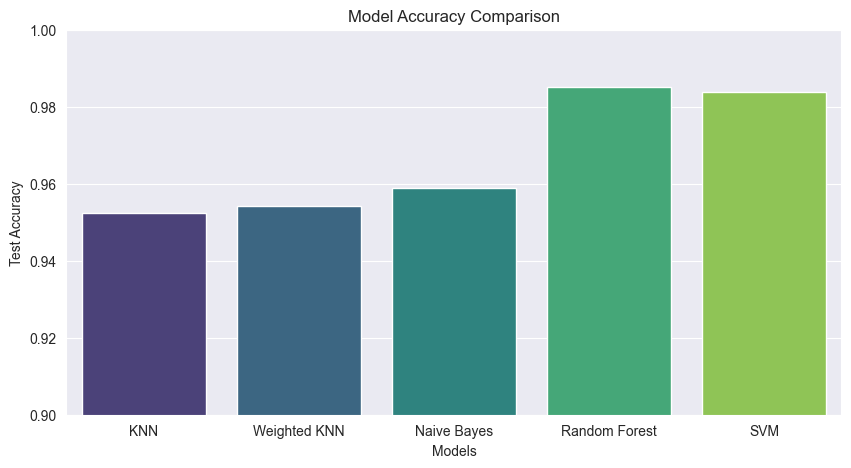

In [29]:
# Accuracy Comparison
plt.figure(figsize=(10, 5))
sns.barplot(x=results_df.index, y=results_df["CV Accuracy Mean"], palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylabel("Test Accuracy")
plt.xlabel("Models")
plt.ylim(0.9, 1)  # Zoom into accuracy range
plt.show()

## **Model Performance Metrics 📊**

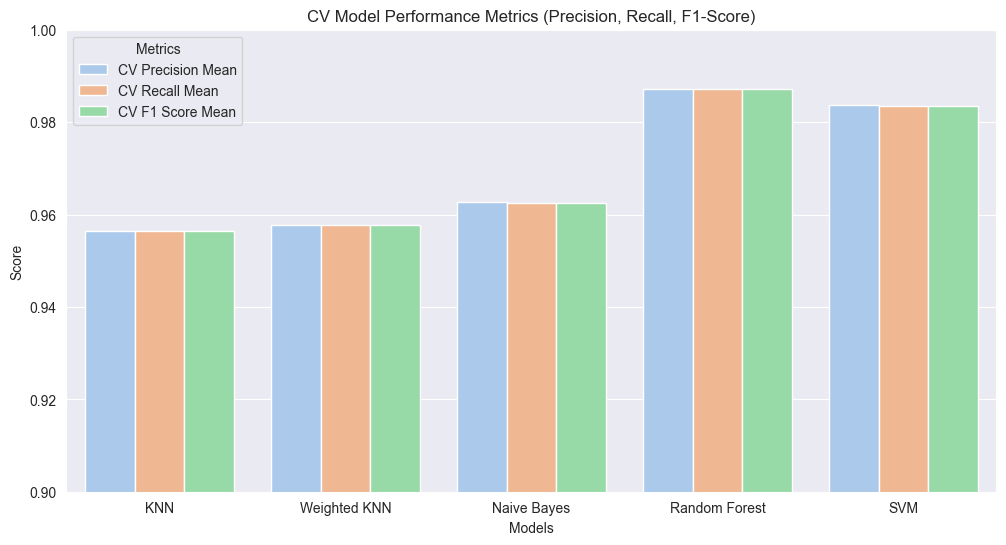

KNN              0.952333
Weighted KNN     0.954133
Naive Bayes      0.958933
Random Forest      0.9852
SVM              0.983717
Name: CV Accuracy Mean, dtype: object
KNN              0.956538
Weighted KNN     0.957771
Naive Bayes      0.962713
Random Forest    0.987272
SVM              0.983615
Name: CV Precision Mean, dtype: object
KNN              0.956467
Weighted KNN     0.957733
Naive Bayes      0.962533
Random Forest    0.987267
SVM              0.983533
Name: CV Recall Mean, dtype: object
KNN              0.956443
Weighted KNN     0.957693
Naive Bayes       0.96257
Random Forest    0.987268
SVM              0.983541
Name: CV F1 Score Mean, dtype: object


In [30]:
# CV Plot Precision, Recall, and F1 Score Comparison
metrics = ["CV Precision Mean", "CV Recall Mean", "CV F1 Score Mean"]
metrics_df = results_df[metrics].melt(ignore_index=False).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x="index", y="value", hue="variable", data=metrics_df, palette="pastel")
plt.title("CV Model Performance Metrics (Precision, Recall, F1-Score)")
plt.ylabel("Score")
plt.xlabel("Models")
plt.ylim(0.9, 1)
plt.legend(title="Metrics")
plt.show()

print(results_df["CV Accuracy Mean"])
print(results_df["CV Precision Mean"])
print(results_df["CV Recall Mean"])
print(results_df["CV F1 Score Mean"])

## **Model Comparison Table for Part 2️⃣ 🧐**

| Model          | CV Accuracy Mean | CV Precision Mean | CV Recall Mean | CV F1 Score Mean |
|----------------|-----------------|-------------------|----------------|------------------|
| KNN            | 0.95475         | 0.955846          | 0.955667       | 0.955590         |
| Weighted KNN   | 0.95475         | 0.955846          | 0.955667       | 0.955590         |
| Naive Bayes    | 0.95950         | 0.960766          | 0.960467       | 0.960499         |
| Random Forest  | 0.98585         | 0.985076          | 0.985067       | 0.985070         |
| SVM            | 0.98355         | 0.983754          | 0.983667       | 0.983674         |


## **Confusion Matrices for Models 🤯**

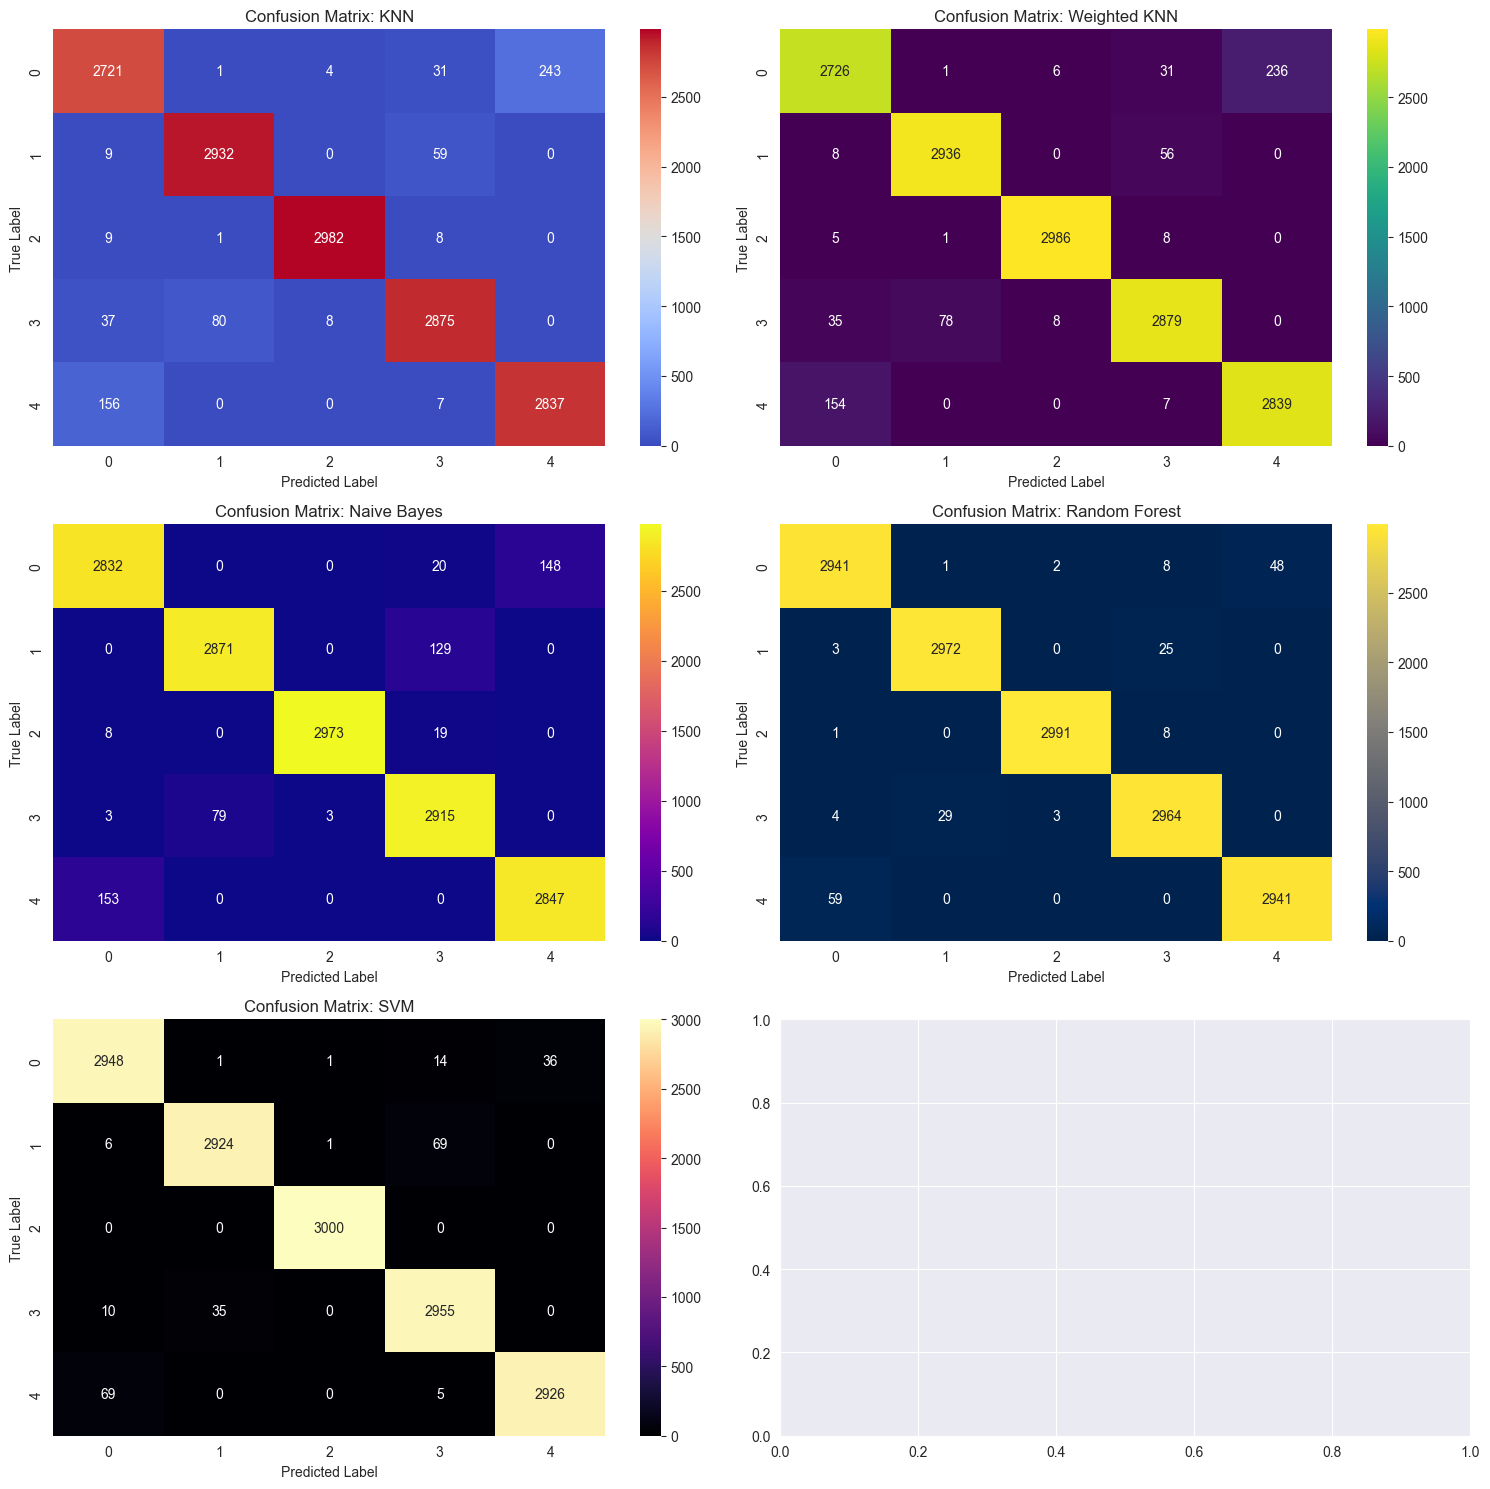

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define color palettes for different models
color_maps = ['coolwarm', 'viridis', 'plasma', 'cividis', 'magma', 'inferno', 'YlGnBu']

# Plot Confusion Matrices for Each Model
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.ravel()

for i, (model_name, model) in enumerate(best_models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap=color_maps[i % len(color_maps)], ax=axes[i])
    axes[i].set_title(f"Confusion Matrix: {model_name}")
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_ylabel("True Label")

plt.tight_layout()
plt.show()